# Banana Brain Navigation

## The Problem

In this project, we train a reinforcement learning agent to navigate and collect bananas in a large, square world. A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana. Thus, we want to collect as many yellow bananas as possible while avoiding blue bananas.

### The Environment

We are using an environment from the Unity ML-Agents plugin for this task.

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around the agent's forward direction. Given this information, the agent has to learn how to best select actions. Four discrete actions are available, corresponding to:

0 - move forward.
1 - move backward.
2 - turn left.
3 - turn right.

We consider the task "solved" when the agent reaches an average score of +13 over 100 consecutive episodes.

The following line sets up our development environment.

In [1]:
!pip -q install ./python

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
ERROR: Invalid requirement: './python'
Hint: It looks like a path. File './python' does not exist.


Next, we load all necessary packages for this task, and explore the environment's state and action space.

In [2]:
from unityagents import UnityEnvironment
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import deque, namedtuple
import random
import matplotlib.pyplot as plt

# load the environment
#env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
print(brain_name)
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


BananaBrain
Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


We are now ready to build the agent.

## The Solution

### DQN

We use a Deep Q-Network (DQN) model to approximate the action-value function of the most recent policy. The network takes in a state through two fully-connected hidden layers of 256 nodes each, producing an output vector the same size as the action space containing the predicted Q-values of each (state, action) pair. The architecture is shown below.

In [3]:
class DQNet(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNet, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.fc_size = 256
        self.fc1 = nn.Linear(self.state_size, self.fc_size)
        self.fc2 = nn.Linear(self.fc_size, self.fc_size)
        self.fc3 = nn.Linear(self.fc_size, self.action_size)
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### A Memory Buffer for Experience Replay

The _ReplayBuffer_ class defined below acts as a memory buffer that collects tuples of _(state, action, reward, next_state, done)_ from each step of the agent's training. The _sample()_ function randomly draws a minibatch of experience tuples from the buffer, which the agent uses to update its Q-network. This enables data efficiency in potentially repeated use of samples, while reducing any sequential dependencies within the episodes.

In [4]:
class ReplayBuffer():
    def __init__(self, buffer_size, num_to_sample, device):
        self.num_to_sample = num_to_sample
        self.buffer = deque(maxlen=int(buffer_size))
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.size = 0
        self.device = device
        
    def add(self, s, a, r, n_s, d):
        self.buffer.append(self.experience(s, a, r, n_s, d))
        self.size += 1
        
    def sample(self):
        experiences = random.sample(self.buffer, k=self.num_to_sample)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([1 if e.done else 0 for e in experiences if e is not None])).float().to(self.device)
        return (states, actions, rewards, next_states, dones)
        
    def get_len(self):
        return self.size

### The Agent

The RL agent is defined below. It has 2 separate Q-networks, one to update more frequently to reflect an expected value for the total reward, and one to update less frequently as a TD target. Decoupling the networks like this and fixing the target network reduces unwanted sequential dependencies in the data that could cause the network to update its parameters based on a moving target.

The local network is updated every 4 time steps and draws a minibatch of size 64 from the replay buffer to update the network's parameters. We use an Adam optimizer to train the local network, with a Mean-Squared Error loss function to compute the TD error. Every 32 steps, we use a parameter tau=0.99 to perform a weighted average update to the target network's weights using the weights of both networks.

When selecting actions based on the given state, the agent uses an epsilon-greedy policy, where the value of epsilon starts at 1 and decays with each time step until it reaches a minimum value of 1e-5.

Other hyperparameters include a learning rate of alpha=5e-4, a reward discount rate of gamma=0.99, and a replay buffer capacity of 1e5.

In [5]:
class Agent():
    def __init__(self, state_size, action_size, gamma=0.99, alpha=5e-4, tau=0.99, update_freq_local=4, update_freq_target=32, buffer_size=1e5, update_batch_size=64):
        # hyperparameters
        self.gamma = gamma
        self.alpha = alpha
        self.update_freq_local = update_freq_local
        self.update_freq_target = update_freq_target  # how many time steps to switch out model_target with model_local
        self.tau = tau
        
        # agent parameters
        self.state_size = state_size
        self.action_size = action_size
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model_local = DQNet(self.state_size, self.action_size).to(self.device)
        self.model_target = DQNet(self.state_size, self.action_size).to(self.device)
        self.optimizer = optim.Adam(self.model_local.parameters(), lr=self.alpha)
        self.update_batch_size = update_batch_size
        self.memory_buffer = ReplayBuffer(buffer_size, self.update_batch_size, self.device)
        self.step_num = 0
        
    def select_action(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.model_local.eval()
        with torch.no_grad():
            action_vals = self.model_local(state)
        self.model_local.train()
        if random.random() < epsilon:
            return np.argmax(action_vals.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def update(self, state, action, reward, next_state, done):
        self.memory_buffer.add(state, action, reward, next_state, done)
        self.step_num += 1
        if self.step_num % self.update_freq_local == 0 and self.memory_buffer.get_len() > self.update_batch_size:
            self.update_local()
        if self.step_num % self.update_freq_target == 0:
            self.update_target()
    
    def update_local(self):
        states, actions, rewards, next_states, dones = self.memory_buffer.sample()
        
        local_vals = self.model_local(states).gather(1, actions)
        
        next_target_vals = self.model_target(next_states).detach().max(1)[0].unsqueeze(1)
        target_vals = rewards + self.gamma * next_target_vals * (1-done)
        
        loss = F.mse_loss(local_vals, target_vals)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def update_target(self):
        for target_param, local_param in zip(self.model_target.parameters(), self.model_local.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)
    

### Putting it Together

Now we can train the agent, using a cap of 1000 episodes of at most 100,000 time steps each. The accumulated reward for the last 100 time steps is saved in the *score\_window* deque, and the task is considered solved when the average value of *score\_window* exceeds 13.0. The model is then saved into _checkpoint.pth_, and a graph of episode scores sampled every 5 episodes (to reduce noise) is plotted.

Starting Training! state_size=37, action_size=4


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode 560/1000: avg score=12.99282828282829
Environment solved in 560 episodes!	Average Score: 13.09


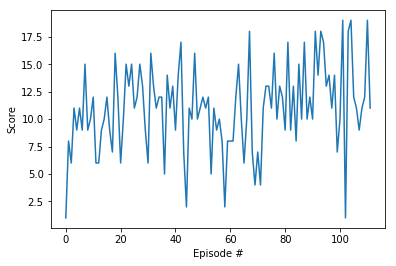

In [6]:
# setup
seed = torch.manual_seed(0)
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size 
state_size = len(env_info.vector_observations[0])
agent = Agent(state_size=state_size, action_size=action_size)
scores = []
score_window = deque(maxlen=100)
num_episodes = 1000
max_timesteps = 100000
epsilon = 1
epsilon_min = 1e-5

# train the agent
print(f'Starting Training! state_size={state_size}, action_size={action_size}')
for ep in range(1, num_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    ep_score = 0
    for step in range(max_timesteps):
        action = agent.select_action(state, epsilon)
        env_info = env.step(action)[brain_name]
        reward = env_info.rewards[0]
        next_state = env_info.vector_observations[0]
        done = env_info.local_done[0]
        agent.update(state, action, reward, next_state, done)
        state = next_state
        ep_score += reward
        epsilon = max(1.0/epsilon, epsilon_min)
        if done:
            break
    print(f'\rEpisode {ep}/{num_episodes}: avg score={np.mean(score_window)}', end="")
    score_window.append(ep_score)
    if (ep-1) % 5 == 0:
        scores.append(ep_score)
    if np.mean(score_window) >= 13.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(ep, np.mean(score_window)))
        break

# save the trained model
torch.save(agent.model_local.state_dict(), 'checkpoint.pth')

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('learning_curve.png')

The results may vary per run, but the model saved in _checkpoint.pth_ solved the environment in 560 episodes, and the corresponding learning curve is saved in *learning\_curve.png*. As shown in the plot, the overall trend of the agent's score in the environment is positive, and the range of oscillation also decreases as the agent becomes more steady in higher-scoring areas with time.

After we obtain satisfactory results, we can close the environment.

In [ ]:
env.close()

Future work would involve ways of helping the agent solve the environment faster, retain an average score across more episodes for consistency, and perhaps even reach a higher average score to solve the task. The architecture of DQN can be modified to create a set of Dueling Networks, or we can further exploit the use of two Q-networks within the agent to smooth the Q-values using a Double DQN error calculation. Additionally, we can assign weights to each experience tuple in the agent's replay buffer to assign priorities based on the TD error associated with the tuple.